In [1]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))
import os, sys

PROJECT_PATH = os.path.join("..")
sys.path.append(PROJECT_PATH)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import datashader as ds
# from datashader import transfer_functions
# import bokeh.plotting as bp
# from matplotlib.cm import viridis
# import datashader as ds
# import holoviews as hv
# print(hv.__version__)
# from holoviews import opts
# from holoviews.operation.datashader import datashade, shade, spread, dynspread, rasterize
# import holoviews.plotting.bokeh
# hv.extension('bokeh','matplotlib')

PROJECT_PATH = os.path.join("..")
sys.path.append(PROJECT_PATH)
from parameters import param_keys, general_keys
from models.classifiers.deepHits_nans_norm_crop_stamp_model import (
    DeepHiTSNanNormCropStampModel,
)
from models.classifiers.deepHits_entopy_reg_model import DeepHiTSEntropyRegModel
from models.classifiers.deepHits_with_features_entropy_reg import (
    DeepHiTSWithFeaturesEntropyReg,
)
from modules.data_loaders.frame_to_input_with_features import FrameToInputWithFeatures
import pickle
from notebooks.evaluate_unlabeled_data import get_predictions_of_chunk
from modules.data_set_generic import Dataset
from scripts.plot_confusion_matrix import plot_confusion_matrix, plot_cm_std
from sklearn.metrics import confusion_matrix
from glob import glob
import tensorflow as tf

# import ephem

# Confusion matrix

In [2]:
# instance model and load weights
data_dir = "../../pickles/"
DATA_PATH = os.path.join(os.path.join(data_dir, "training_set_May-06-2020.pkl"))
# DATA_PATH = "../../pickles/converted_data.pkl"
N_CLASSES = 5

features_keys = [
    "oid",
    "sgscore1",
    "distpsnr1",
    "sgscore2",
    "distpsnr2",
    "sgscore3",
    "distpsnr3",
    "isdiffpos",
    "fwhm",
    "magpsf",
    "sigmapsf",
    "ra",
    "dec",
    "diffmaglim",
    "rb",
    "distnr",
    "magnr",
    "classtar",
    "ndethist",
    "ncovhist",
    "ecl_lat",
    "ecl_long",
    "gal_lat",
    "gal_long",
    "non_detections",
    "chinr",
    "sharpnr",
]

n_classes = 5
params = {
    param_keys.RESULTS_FOLDER_NAME: "aux_model",
    param_keys.DATA_PATH_TRAIN: DATA_PATH,
    param_keys.WAIT_FIRST_EPOCH: False,
    param_keys.N_INPUT_CHANNELS: 3,
    param_keys.CHANNELS_TO_USE: [0, 1, 2],
    param_keys.TRAIN_ITERATIONS_HORIZON: 30000,
    param_keys.TRAIN_HORIZON_INCREMENT: 10000,
    param_keys.TEST_SIZE: n_classes * 100,
    param_keys.VAL_SIZE: n_classes * 100,
    param_keys.NANS_TO: 0,
    param_keys.NUMBER_OF_CLASSES: n_classes,
    param_keys.CROP_SIZE: 21,
    param_keys.INPUT_IMAGE_SIZE: 21,
    param_keys.LEARNING_RATE: 0.0001,
    param_keys.VALIDATION_MONITOR: general_keys.LOSS,
    param_keys.VALIDATION_MODE: general_keys.MIN,
    param_keys.ENTROPY_REG_BETA: 0.8,
    param_keys.DROP_RATE: 0.8,
    param_keys.BATCH_SIZE: 32,
    param_keys.KERNEL_SIZE: 3,
    param_keys.FEATURES_NAMES_LIST: [
        "oid",
        "sgscore1",
        "distpsnr1",
        "sgscore2",
        "distpsnr2",
        "sgscore3",
        "distpsnr3",
        "isdiffpos",
        "fwhm",
        "magpsf",
        "sigmapsf",
        "ra",
        "dec",
        "diffmaglim",
        "rb",
        "distnr",
        "magnr",
        "classtar",
        "ndethist",
        "ncovhist",
        "ecl_lat",
        "ecl_long",
        "gal_lat",
        "gal_long",
        "non_detections",
        "chinr",
        "sharpnr",
    ],
    param_keys.BATCHNORM_FEATURES_FC: True,
    param_keys.FEATURES_CLIPPING_DICT: {
        "sgscore1": [-1, "max"],
        "distpsnr1": [-1, "max"],
        "sgscore2": [-1, "max"],
        "distpsnr2": [-1, "max"],
        "sgscore3": [-1, "max"],
        "distpsnr3": [-1, "max"],
        "fwhm": ["min", 10],
        "distnr": [-1, "max"],
        "magnr": [-1, "max"],
        "ndethist": ["min", 20],
        "ncovhist": ["min", 3000],
        "chinr": [-1, 15],
        "sharpnr": [-1, 1.5],
        "non_detections": ["min", 2000],
    },
}
aux_model = DeepHiTSWithFeaturesEntropyReg(params)
params = aux_model.params
train_set, val_set, test_set = aux_model._prepare_input()
aux_model.close()
del aux_model
# aux_model.close()
# del aux_model

# frame_to_input = FrameToInputWithFeatures(params)
# frame_to_input.set_dumping_data_to_pickle(False)
# frame_to_input.dataset_preprocessor.set_pipeline(
#          [frame_to_input.dataset_preprocessor.image_check_single_image,
#           frame_to_input.dataset_preprocessor.image_clean_misshaped,
#           frame_to_input.dataset_preprocessor.image_select_channels,
#           frame_to_input.dataset_preprocessor.image_crop_at_center,
#           frame_to_input.dataset_preprocessor.image_normalize_by_image,
#           frame_to_input.dataset_preprocessor.image_nan_to_num,
#           frame_to_input.dataset_preprocessor.features_clip,
#           frame_to_input.dataset_preprocessor.features_normalize
#           ])


# data_dict = frame_to_input.get_preprocessed_datasets_splitted()
# train_set, val_set, test_set = data_dict["train"], data_dict["validation"], data_dict["test"]

W0525 18:40:39.078738 139725502879552 deprecation_wrapper.py:119] From /home/ereyes/Projects/Alerce/stamp_classifier/modules/iterators/train_iterator_with_features.py:29: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0525 18:40:39.321325 139725502879552 deprecation.py:323] From /home/ereyes/Projects/Alerce/stamp_classifier/modules/iterators/train_iterator.py:61: DatasetV1.make_initializable_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.
W0525 18:40:39.455255 139725502879552 deprecation_wrapper.py:119] From /home/ereyes/Projects/Alerce/stamp_classifier/modules/iterators/train_iterator.py:65: The name tf.data.Iterator is deprecated. Pl

{'AGN': 0, 'SN': 1, 'VS': 2, 'asteroid': 3, 'bogus': 4}
Dumping to /home/ereyes/Projects/Alerce/stamp_classifier/../pickles/converted_data.pkl...
Label count AGN: 14966 -SN: 1620 -VS: 14996 -asteroid: 9899 -bogus: 10763 -
650 misshaped samples removed
Label count AGN: 14742 -SN: 1596 -VS: 14723 -asteroid: 9799 -bogus: 10734 -
2598 samples with NaNs. NaNs replaced with number 0
Calculating feature statistics for normalization, with set of size 50594


In [3]:
test_set

In [4]:
params.update(
    {
        param_keys.FEATURES_NAMES_LIST: [
            "sgscore1",
            "distpsnr1",
            "sgscore2",
            "distpsnr2",
            "sgscore3",
            "distpsnr3",
            "isdiffpos",
            "fwhm",
            "magpsf",
            "sigmapsf",
            "ra",
            "dec",
            "diffmaglim",
            "rb",
            "distnr",
            "magnr",
            "classtar",
            "ndethist",
            "ncovhist",
            "ecl_lat",
            "ecl_long",
            "gal_lat",
            "gal_long",
            "non_detections",
            "chinr",
            "sharpnr",
        ],
        param_keys.DATA_PATH_TRAIN: None,
    }
)
results_folder_path = os.path.join("..", "results", "final_hyperparam_search")
model_name = (
    "DeepHits_EntropyRegBeta%.4f_batch%d_lr%.5f_droprate%.4f_inputsize%d_filtersize%d_*"
    % (
        params[param_keys.ENTROPY_REG_BETA],
        params[param_keys.BATCH_SIZE],
        params[param_keys.LEARNING_RATE],
        params[param_keys.DROP_RATE],
        params[param_keys.INPUT_IMAGE_SIZE],
        params[param_keys.KERNEL_SIZE],
    )
)
model_paths = glob(
    os.path.join(
        "../results/LA_MEJOR_WEA/",
        "DeepHits_EntropyRegBeta0.8000_batch32_lr0.00100_droprate0.8000_inputsize21_filtersize3_*",
    )
)
# model_paths = glob(os.path.join(
#     results_folder_path, 'DeepHits_EntropyRegBeta0.8000_batch32_lr0.00100_droprate0.8000_inputsize21_filtersize3_*'))

print(os.path.abspath(results_folder_path))
print(model_paths)
print(model_name)
print(os.path.join(results_folder_path, model_name))

/home/ereyes/Projects/Alerce/stamp_classifier/results/final_hyperparam_search
['../results/LA_MEJOR_WEA/DeepHits_EntropyRegBeta0.8000_batch32_lr0.00100_droprate0.8000_inputsize21_filtersize3_0_20200518-115007', '../results/LA_MEJOR_WEA/DeepHits_EntropyRegBeta0.8000_batch32_lr0.00100_droprate0.8000_inputsize21_filtersize3_2_20200518-120544', '../results/LA_MEJOR_WEA/DeepHits_EntropyRegBeta0.8000_batch32_lr0.00100_droprate0.8000_inputsize21_filtersize3_1_20200518-115756', '../results/LA_MEJOR_WEA/DeepHits_EntropyRegBeta0.8000_batch32_lr0.00100_droprate0.8000_inputsize21_filtersize3_3_20200518-121332', '../results/LA_MEJOR_WEA/DeepHits_EntropyRegBeta0.8000_batch32_lr0.00100_droprate0.8000_inputsize21_filtersize3_4_20200518-122120']
DeepHits_EntropyRegBeta0.8000_batch32_lr0.00010_droprate0.8000_inputsize21_filtersize3_*
../results/final_hyperparam_search/DeepHits_EntropyRegBeta0.8000_batch32_lr0.00010_droprate0.8000_inputsize21_filtersize3_*


In [5]:
feature_model_list = []
for model_path in model_paths:
    graph = tf.Graph()
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(graph=graph, config=config)
    with graph.as_default():
        model = DeepHiTSWithFeaturesEntropyReg(params, session=sess)
        checkpoint_path_best_so_far = os.path.join(model_path, "checkpoints", "model")
        model.load_model(checkpoint_path_best_so_far)
        feature_model_list.append(model)


# model_paths = glob(os.path.join("../results/best_model_without_features_extra_layer/",'DeepHits_EntropyRegBeta0.8000_batch32_lr0.00100_droprate0.8000_inputsize21_filtersize3_*'))
# model_list = []
# for model_path in model_paths:
#     graph = tf.Graph()
#     config = tf.ConfigProto()
#     config.gpu_options.allow_growth = True
#     sess = tf.Session(graph=graph, config=config)
#     with graph.as_default():
#         model = DeepHiTSEntropyRegModel(params, session=sess)
#         checkpoint_path_best_so_far = os.path.join(model_path, "checkpoints", 'model')
#         model.load_model(checkpoint_path_best_so_far)
#         model_list.append(model)

W0525 18:42:21.954709 139725502879552 deprecation.py:323] From /home/ereyes/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Normalized confusion matrix Acc 0.9300
Normalized confusion matrix Acc 0.9520
Normalized confusion matrix Acc 0.9460
Normalized confusion matrix Acc 0.9440
Normalized confusion matrix Acc 0.9480
0.9440000000000002 0.007483314773547849
[[0.93 0.01 0.05 0.   0.  ]
 [0.01 0.88 0.01 0.07 0.03]
 [0.03 0.   0.97 0.   0.  ]
 [0.   0.01 0.01 0.98 0.  ]
 [0.   0.02 0.01 0.01 0.96]]


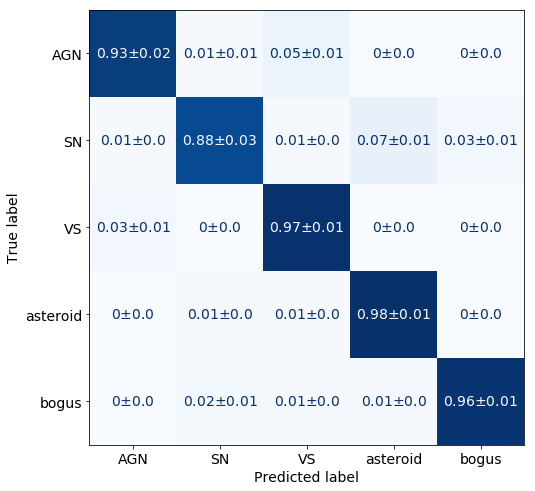

In [6]:
normalize_cm = True
class_names = np.array(["AGN", "SN", "VS", "asteroid", "bogus"])
all_cms = []

predictions_with_features_per_model = []

acc = []
for model in feature_model_list:
    y_pred = model.predict(test_set.data_array, features=test_set.meta_data[:, 1:])
    acc.append(np.mean(y_pred == test_set.data_label))
    predictions_with_features_per_model.append(
        {
            "prediction": y_pred,
            "prob": model.predict_proba(
                test_set.data_array, features=test_set.meta_data[:, 1:]
            ),
        }
    )
    cm = confusion_matrix(test_set.data_label, y_pred)
    if normalize_cm:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix Acc %.4f" % (np.trace(cm) / np.sum(cm)))
    all_cms.append(cm)

print(np.mean(acc), np.std(acc))
all_cms = np.stack(all_cms)
mean_cm, std_cm = np.mean(all_cms, axis=0), np.std(all_cms, axis=0)

%matplotlib inline
p = plot_cm_std(
    mean_cm=mean_cm,
    std_cm=std_cm,
    title="",
    classes=class_names,
    normalize=True,
    label_fontsize=14,
    axis_fontsize=14,
    colorbar=False,
    savepath="revision_plots/mean_matrix.pdf",
)
plt.show()

### Validation set

In [ ]:
normalize_cm = True
class_names = np.array(["AGN", "SN", "VS", "asteroid", "bogus"])
all_cms = []

predictions_with_features_per_model = []

acc = []
for model in feature_model_list:
    y_pred = model.predict(val_set.data_array, features=val_set.meta_data[:, 1:])
    acc.append(np.mean(y_pred == val_set.data_label))
    predictions_with_features_per_model.append(
        {
            "prediction": y_pred,
            "prob": model.predict_proba(
                val_set.data_array, features=val_set.meta_data[:, 1:]
            ),
        }
    )
    cm = confusion_matrix(val_set.data_label, y_pred)
    if normalize_cm:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix Acc %.4f" % (np.trace(cm) / np.sum(cm)))
    all_cms.append(cm)


print(np.mean(acc), np.std(acc))
all_cms = np.stack(all_cms)
mean_cm, std_cm = np.mean(all_cms, axis=0), np.std(all_cms, axis=0)

%matplotlib inline
p = plot_cm_std(
    mean_cm=mean_cm,
    std_cm=std_cm,
    title="",
    classes=class_names,
    normalize=True,
    label_fontsize=14,
    axis_fontsize=14,
    colorbar=False,
    savepath="revision_plots/mean_matrix.pdf",
)
plt.show()

In [ ]:
normalize_cm = True
class_names = np.array(["AGN", "SN", "VS", "asteroid", "bogus"])
all_cms = []
for model in model_list:
    y_pred = model.predict(test_set.data_array)
    cm = confusion_matrix(test_set.data_label, y_pred)
    if normalize_cm:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix Acc %.4f" % (np.trace(cm) / np.sum(cm)))
    all_cms.append(cm)

all_cms = np.stack(all_cms)
mean_cm, std_cm = np.mean(all_cms, axis=0), np.std(all_cms, axis=0)

%matplotlib inline
p = plot_cm_std(
    mean_cm=mean_cm,
    std_cm=std_cm,
    title="Test set",
    classes=class_names,
    normalize=True,
    label_fontsize=14,
    axis_fontsize=14,
    colorbar=False,
    savepath="revision_plots/mean_matrix_no_feat.pdf",
)
plt.show()

# Plot SN examples

In [ ]:
def plot_examples(image_input, predictions, class_names, ztf_id, image_name):
    f, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(image_input[..., 0], cmap="inferno")
    ax[1].imshow(image_input[..., 1], cmap="inferno")
    ax[2].imshow(image_input[..., 2], cmap="inferno")
    ax[0].axis("off")
    ax[1].axis("off")
    ax[2].axis("off")
    prob_str = "Predicted probabilities:\n"
    for c, p in enumerate(predictions):
        prob_str += class_names[c] + ": " + str(np.round(p, 3)) + ", "
    ax[1].set_title(prob_str[:-2], fontsize=18)
    print(prob_str)
    print(predictions)
    print(ztf_id)
    plt.savefig("revision_plots/sn_samples/" + image_name, bbox_inches="tight")
    plt.show()


class_names = ["AGN", "SN", "VS", "asteroid", "bogus"]
model = feature_model_list[0]
for i in range(500):
    if test_set.data_label[i] == 1:
        pred = model.predict_proba(
            test_set.data_array[i, :], features=test_set.meta_data[i, 1:]
        )
        pred = pred[0, ...]
        ztf_id = test_set.meta_data[i, 0]
        image_name = ztf_id + ".pdf"
        plot_examples(test_set.data_array[i, :], pred, class_names, ztf_id, image_name)

# Histogram array for each feature

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import pandas as pd

In [ ]:
data_dir = "../../pickles/"
data_path = os.path.join(os.path.join(data_dir, "training_set_May-06-2020.pkl"))
dataset = pd.read_pickle(data_path)
dataset.loc[dataset.isdiffpos == "f", "isdiffpos"] = 0.0
dataset.loc[dataset.isdiffpos == "t", "isdiffpos"] = 1.0

features_keys = [
    "sgscore1",
    "distpsnr1",
    "sgscore2",
    "distpsnr2",
    "sgscore3",
    "distpsnr3",
    "isdiffpos",
    "fwhm",
    "magpsf",
    "sigmapsf",
    "ra",
    "dec",
    "diffmaglim",
    "rb",
    "distnr",
    "magnr",
    "classtar",
    "ndethist",
    "ncovhist",
    "ecl_lat",
    "ecl_long",
    "gal_lat",
    "gal_long",
    "non_detections",
    "chinr",
    "sharpnr",
]

for fk in features_keys:
    dataset[fk] = dataset[fk].astype("float64")

clipping_values = {
    "sgscore1": [-1, "max"],
    "distpsnr1": [-1, "max"],
    "sgscore2": [-1, "max"],
    "distpsnr2": [-1, "max"],
    "sgscore3": [-1, "max"],
    "distpsnr3": [-1, "max"],
    "fwhm": ["min", 10],
    "distnr": [-1, "max"],
    "magnr": [-1, "max"],
    "ndethist": ["min", 20],
    "ncovhist": ["min", 3000],
    "chinr": [-1, 15],
    "sharpnr": [-1, 1.5],
    "non_detections": ["min", 2000],
}

for k, clip_range in clipping_values.items():
    if clip_range[0] == "min":
        lower_clip = np.min(dataset[k])
    else:
        lower_clip = clip_range[0]
    if clip_range[1] == "max":
        upper_clip = np.max(dataset[k])
    else:
        upper_clip = clip_range[1]

    dataset[k] = dataset[k].clip(lower=lower_clip, upper=upper_clip)

In [ ]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]


sub_class_metadata = {}
for cl in np.unique(dataset["class"]):
    sub_class_metadata[cl] = dataset[dataset["class"] == cl][features_keys]

fontsize = 15
n_bins = 50
cols = 4
rows = 7
f, ax = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
ax = trim_axs(ax, 26)
for i, fk in enumerate(features_keys):
    for cl, md in sub_class_metadata.items():
        values = md[fk].values
        values = values[np.logical_not(np.isnan(values))]
        h, b = np.histogram(md[fk], bins=n_bins, density=True)
        ax[i].plot(b[1:], h, lw=3, label=cl)
    if i == 0:
        ax[i].legend(fontsize=fontsize - 1)
    ax[i].tick_params(axis="both", labelsize=fontsize)
    ax[i].set_xlabel(fk, fontsize=fontsize)
    # ax.set_ylabel("Normalized histogram", fontsize=fontsize)
    ax[i].grid()
plt.subplots_adjust(wspace=0.21, hspace=0.25)
plt.savefig("revision_plots/features_grid.pdf", bbox_inches="tight")
plt.show()

# Beta variation

In [ ]:
# instance model and load weights
data_dir = "../../pickles/"
DATA_PATH = os.path.join(os.path.join(data_dir, "training_set_May-06-2020.pkl"))
# DATA_PATH = "../../pickles/converted_data.pkl"
N_CLASSES = 5

features_keys = [
    "oid",
    "sgscore1",
    "distpsnr1",
    "sgscore2",
    "distpsnr2",
    "sgscore3",
    "distpsnr3",
    "isdiffpos",
    "fwhm",
    "magpsf",
    "sigmapsf",
    "ra",
    "dec",
    "diffmaglim",
    "rb",
    "distnr",
    "magnr",
    "classtar",
    "ndethist",
    "ncovhist",
    "ecl_lat",
    "ecl_long",
    "gal_lat",
    "gal_long",
    "non_detections",
    "chinr",
    "sharpnr",
]

n_classes = 5
params = {
    param_keys.RESULTS_FOLDER_NAME: "aux_model",
    param_keys.DATA_PATH_TRAIN: DATA_PATH,
    param_keys.WAIT_FIRST_EPOCH: False,
    param_keys.N_INPUT_CHANNELS: 3,
    param_keys.CHANNELS_TO_USE: [0, 1, 2],
    param_keys.TRAIN_ITERATIONS_HORIZON: 30000,
    param_keys.TRAIN_HORIZON_INCREMENT: 10000,
    param_keys.TEST_SIZE: n_classes * 100,
    param_keys.VAL_SIZE: n_classes * 100,
    param_keys.NANS_TO: 0,
    param_keys.NUMBER_OF_CLASSES: n_classes,
    param_keys.CROP_SIZE: 21,
    param_keys.INPUT_IMAGE_SIZE: 21,
    param_keys.LEARNING_RATE: 0.0001,
    param_keys.VALIDATION_MONITOR: general_keys.LOSS,
    param_keys.VALIDATION_MODE: general_keys.MIN,
    param_keys.ENTROPY_REG_BETA: 0.0,
    param_keys.DROP_RATE: 0.8,
    param_keys.BATCH_SIZE: 32,
    param_keys.KERNEL_SIZE: 3,
    param_keys.FEATURES_NAMES_LIST: [
        "sgscore1",
        "distpsnr1",
        "sgscore2",
        "distpsnr2",
        "sgscore3",
        "distpsnr3",
        "isdiffpos",
        "fwhm",
        "magpsf",
        "sigmapsf",
        "ra",
        "dec",
        "diffmaglim",
        "rb",
        "distnr",
        "magnr",
        "classtar",
        "ndethist",
        "ncovhist",
        "ecl_lat",
        "ecl_long",
        "gal_lat",
        "gal_long",
        "non_detections",
        "chinr",
        "sharpnr",
    ],
    param_keys.BATCHNORM_FEATURES_FC: True,
    param_keys.FEATURES_CLIPPING_DICT: {
        "sgscore1": [-1, "max"],
        "distpsnr1": [-1, "max"],
        "sgscore2": [-1, "max"],
        "distpsnr2": [-1, "max"],
        "sgscore3": [-1, "max"],
        "distpsnr3": [-1, "max"],
        "fwhm": ["min", 10],
        "distnr": [-1, "max"],
        "magnr": [-1, "max"],
        "ndethist": ["min", 20],
        "ncovhist": ["min", 3000],
        "chinr": [-1, 15],
        "sharpnr": [-1, 1.5],
        "non_detections": ["min", 2000],
    },
}
aux_model = DeepHiTSWithFeaturesEntropyReg(params)
params = aux_model.params
aux_model.close()
del aux_model

frame_to_input = FrameToInputWithFeatures(params)
frame_to_input.set_dumping_data_to_pickle(False)
frame_to_input.dataset_preprocessor.set_pipeline(
    [
        frame_to_input.dataset_preprocessor.image_check_single_image,
        frame_to_input.dataset_preprocessor.image_clean_misshaped,
        frame_to_input.dataset_preprocessor.image_select_channels,
        frame_to_input.dataset_preprocessor.image_crop_at_center,
        frame_to_input.dataset_preprocessor.image_normalize_by_image,
        frame_to_input.dataset_preprocessor.image_nan_to_num,
        frame_to_input.dataset_preprocessor.features_clip,
        frame_to_input.dataset_preprocessor.features_normalize,
    ]
)

data_dict = frame_to_input.get_preprocessed_datasets_splitted()
train_set, val_set, test_set = (
    data_dict["train"],
    data_dict["validation"],
    data_dict["test"],
)

In [ ]:
params.update(
    {
        param_keys.FEATURES_NAMES_LIST: [
            "sgscore1",
            "distpsnr1",
            "sgscore2",
            "distpsnr2",
            "sgscore3",
            "distpsnr3",
            "isdiffpos",
            "fwhm",
            "magpsf",
            "sigmapsf",
            "ra",
            "dec",
            "diffmaglim",
            "rb",
            "distnr",
            "magnr",
            "classtar",
            "ndethist",
            "ncovhist",
            "ecl_lat",
            "ecl_long",
            "gal_lat",
            "gal_long",
            "non_detections",
            "chinr",
            "sharpnr",
        ],
        param_keys.DATA_PATH_TRAIN: None,
    }
)


graph = tf.Graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(graph=graph, config=config)
with graph.as_default():
    regular_model = DeepHiTSWithFeaturesEntropyReg(params, session=sess)
    checkpoint_path_best_so_far = os.path.join(
        PROJECT_PATH,
        "results/best_model_paper_beta_comparison/DeepHits_EntropyRegBeta0.0000_batch32_lr0.00100_droprate0.8000_inputsize21_filtersize3_0_20200522-220930/checkpoints",
        "model",
    )
    regular_model.load_model(checkpoint_path_best_so_far)

params_entropy_05 = params.copy()
params_entropy_05.update({param_keys.ENTROPY_REG_BETA: 0.5})

graph3 = tf.Graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess3 = tf.Session(graph=graph3, config=config)
with graph3.as_default():
    model_entropy_05 = DeepHiTSWithFeaturesEntropyReg(params_entropy_05, session=sess3)
    checkpoint_path_entropy = os.path.join(
        PROJECT_PATH,
        "results/best_model_paper_beta_comparison/DeepHits_EntropyRegBeta0.5000_batch32_lr0.00100_droprate0.8000_inputsize21_filtersize3_0_20200522-221935/checkpoints",
        "model",
    )
    model_entropy_05.load_model(checkpoint_path_entropy)

params_entropy_1 = params.copy()
params_entropy_1.update({param_keys.ENTROPY_REG_BETA: 1.0})

graph4 = tf.Graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess4 = tf.Session(graph=graph4, config=config)
with graph4.as_default():
    model_entropy_1 = DeepHiTSWithFeaturesEntropyReg(params_entropy_1, session=sess4)
    checkpoint_path_entropy = os.path.join(
        PROJECT_PATH,
        "results/best_model_paper_beta_comparison/DeepHits_EntropyRegBeta1.0000_batch32_lr0.00100_droprate0.8000_inputsize21_filtersize3_0_20200522-222947/checkpoints",
        "model",
    )
    model_entropy_1.load_model(checkpoint_path_entropy)

models = [regular_model, model_entropy_05, model_entropy_1]
model_name = ["beta 0", "beta 0.5", "beta 1.0"]

print(test_set.data_array.shape)
print(test_set.data_label.shape)
print(np.unique(test_set.data_label))
name_label = {"AGN": 0, "SN": 1, "VS": 2, "asteroid": 3, "bogus": 4}
label_name = {y: x for x, y in name_label.items()}

preds = []
for i, m in enumerate(models):
    model_pred = m.predict_proba(train_set.data_array, features=train_set.meta_data)
    preds.append(model_pred)

In [ ]:
%matplotlib inline


def confidence_grid(
    labels,
    models_probs,
    label_name,
    experiments,
    bins=10,
    fontsize=14,
    save_path=None,
    titles=None,
):
    classes = np.unique(labels)
    f, ax = plt.subplots(
        len(models_probs),
        len(classes),
        figsize=(20, 6),
        sharex=True,
        sharey=True,
        gridspec_kw={"hspace": 0, "wspace": 0},
    )
    for i, model_prob in enumerate(models_probs):
        experiment = experiments[i]
        for super_c in classes:
            for c in classes:
                class_index = np.where(labels == super_c)[0]
                probs_class_c = model_prob[class_index, c]
                ax[i][super_c].hist(
                    probs_class_c,
                    bins=bins,
                    label=label_name[c],
                    alpha=0.5,
                    density=True,
                )
            ax[i][super_c].set_xlim([0, 1])
            ax[i][super_c].set_ylim([0, 25])
            ax[i][super_c].set_xlabel("class probability", fontsize=fontsize)
            ax[i][super_c].set_xticks(np.arange(0.1, 1.0, step=0.2))
            ax[i][super_c].set_yticks(np.arange(0, 24, step=5))
            ax[i][super_c].tick_params(axis="both", labelsize=14)
            ax[0][super_c].set_title(titles[super_c], fontsize=fontsize)
        ax[i][0].set_ylabel(experiment, fontsize=fontsize)
        ax[0][len(classes) - 1].legend()
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()


titles = [
    "Active Galactic Nuclei",
    "Supernovae",
    "Variable Stars",
    "Asteroids",
    "Bogus",
]
confidence_grid(
    train_set.data_label,
    preds,
    label_name,
    model_name,
    bins=100,
    save_path="revision_plots/beta_variation.pdf",
    titles=titles,
    fontsize=16,
)

# ROC Curve

In [ ]:
beta5_paths = glob(
    os.path.join(
        PROJECT_PATH,
        "results/beta_comparison_for_roc/DeepHits_EntropyRegBeta0.8000_batch32_lr0.00100_droprate0.8000_inputsize21_filtersize3_*",
    )
)

normal_model_paths = glob(
    os.path.join(
        PROJECT_PATH,
        "results/beta_comparison_for_roc/DeepHits_EntropyRegBeta0.0000_batch32_lr0.00100_droprate0.8000_inputsize21_filtersize3_*",
    )
)

In [ ]:
beta5_paths

In [ ]:
# instance model and load weights
data_dir = "../../pickles/"
DATA_PATH = os.path.join(os.path.join(data_dir, "training_set_May-06-2020.pkl"))
# DATA_PATH = "../../pickles/converted_data.pkl"
N_CLASSES = 5

features_keys = [
    "oid",
    "sgscore1",
    "distpsnr1",
    "sgscore2",
    "distpsnr2",
    "sgscore3",
    "distpsnr3",
    "isdiffpos",
    "fwhm",
    "magpsf",
    "sigmapsf",
    "ra",
    "dec",
    "diffmaglim",
    "rb",
    "distnr",
    "magnr",
    "classtar",
    "ndethist",
    "ncovhist",
    "ecl_lat",
    "ecl_long",
    "gal_lat",
    "gal_long",
    "non_detections",
    "chinr",
    "sharpnr",
]

n_classes = 5
params = {
    param_keys.RESULTS_FOLDER_NAME: "aux_model",
    param_keys.DATA_PATH_TRAIN: DATA_PATH,
    param_keys.WAIT_FIRST_EPOCH: False,
    param_keys.N_INPUT_CHANNELS: 3,
    param_keys.CHANNELS_TO_USE: [0, 1, 2],
    param_keys.TRAIN_ITERATIONS_HORIZON: 30000,
    param_keys.TRAIN_HORIZON_INCREMENT: 10000,
    param_keys.TEST_SIZE: n_classes * 100,
    param_keys.VAL_SIZE: n_classes * 100,
    param_keys.NANS_TO: 0,
    param_keys.NUMBER_OF_CLASSES: n_classes,
    param_keys.CROP_SIZE: 21,
    param_keys.INPUT_IMAGE_SIZE: 21,
    param_keys.LEARNING_RATE: 0.0001,
    param_keys.VALIDATION_MONITOR: general_keys.LOSS,
    param_keys.VALIDATION_MODE: general_keys.MIN,
    param_keys.ENTROPY_REG_BETA: 0.0,
    param_keys.DROP_RATE: 0.8,
    param_keys.BATCH_SIZE: 32,
    param_keys.KERNEL_SIZE: 3,
    param_keys.FEATURES_NAMES_LIST: [
        "sgscore1",
        "distpsnr1",
        "sgscore2",
        "distpsnr2",
        "sgscore3",
        "distpsnr3",
        "isdiffpos",
        "fwhm",
        "magpsf",
        "sigmapsf",
        "ra",
        "dec",
        "diffmaglim",
        "rb",
        "distnr",
        "magnr",
        "classtar",
        "ndethist",
        "ncovhist",
        "ecl_lat",
        "ecl_long",
        "gal_lat",
        "gal_long",
        "non_detections",
        "chinr",
        "sharpnr",
    ],
    param_keys.BATCHNORM_FEATURES_FC: True,
    param_keys.FEATURES_CLIPPING_DICT: {
        "sgscore1": [-1, "max"],
        "distpsnr1": [-1, "max"],
        "sgscore2": [-1, "max"],
        "distpsnr2": [-1, "max"],
        "sgscore3": [-1, "max"],
        "distpsnr3": [-1, "max"],
        "fwhm": ["min", 10],
        "distnr": [-1, "max"],
        "magnr": [-1, "max"],
        "ndethist": ["min", 20],
        "ncovhist": ["min", 3000],
        "chinr": [-1, 15],
        "sharpnr": [-1, 1.5],
        "non_detections": ["min", 2000],
    },
}
aux_model = DeepHiTSWithFeaturesEntropyReg(params)
params = aux_model.params
aux_model.close()
del aux_model

frame_to_input = FrameToInputWithFeatures(params)
frame_to_input.set_dumping_data_to_pickle(False)
frame_to_input.dataset_preprocessor.set_pipeline(
    [
        frame_to_input.dataset_preprocessor.image_check_single_image,
        frame_to_input.dataset_preprocessor.image_clean_misshaped,
        frame_to_input.dataset_preprocessor.image_select_channels,
        frame_to_input.dataset_preprocessor.image_crop_at_center,
        frame_to_input.dataset_preprocessor.image_normalize_by_image,
        frame_to_input.dataset_preprocessor.image_nan_to_num,
        frame_to_input.dataset_preprocessor.features_clip,
        frame_to_input.dataset_preprocessor.features_normalize,
    ]
)

data_dict = frame_to_input.get_preprocessed_datasets_splitted()
train_set, val_set, test_set = (
    data_dict["train"],
    data_dict["validation"],
    data_dict["test"],
)

In [ ]:
model_list = []

normal_model_list = []

for model_path in normal_model_paths:
    graph = tf.Graph()
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(graph=graph, config=config)

    with graph.as_default():
        regular_model = DeepHiTSWithFeaturesEntropyReg(params, session=sess)
        checkpoint_path_best_so_far = os.path.join(model_path + "/checkpoints", "model")
        regular_model.load_model(checkpoint_path_best_so_far)
        normal_model_list.append(regular_model)

params.update({param_keys.ENTROPY_REG_BETA: 0.5})

for model_path in beta5_paths:
    graph = tf.Graph()
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(graph=graph, config=config)

    with graph.as_default():
        regular_model = DeepHiTSWithFeaturesEntropyReg(params, session=sess)
        checkpoint_path_best_so_far = os.path.join(model_path + "/checkpoints", "model")
        regular_model.load_model(checkpoint_path_best_so_far)
        model_list.append(regular_model)

In [ ]:
def get_roc(prob, labels, n_th=500):
    total_true = np.sum(labels == 1)
    total_false = np.sum(labels == 0)

    precision = []
    recall = []

    roc_x = []
    roc_y = []

    for th in np.linspace(start=0, stop=1, num=n_th):

        true_positive = np.sum(np.logical_and(prob >= th, labels == 1)) / np.sum(labels)
        true_negative = np.sum(np.logical_and(prob < th, labels == 0)) / np.sum(
            np.logical_not(labels)
        )
        false_positive = np.sum(np.logical_and(prob >= th, labels == 0)) / np.sum(
            np.logical_not(labels)
        )
        false_negative = np.sum(np.logical_and(prob < th, labels == 1)) / np.sum(labels)

        th_recall = true_positive / (true_positive + false_negative)
        th_precision = true_positive / (true_positive + false_positive)

        recall.append(th_recall)
        precision.append(th_precision)
        roc_x.append(false_positive)
        roc_y.append(true_positive)

    return np.array(roc_x), np.array(roc_y), np.linspace(start=0, stop=1, num=n_th)

In [ ]:
roc_curves = []
normal_roc_curves = []
for i, model in enumerate(model_list):
    probabilities = model.predict_proba(
        test_set.data_array, features=test_set.meta_data
    )
    sn_pred = probabilities[:, 1]
    sn_labels = test_set.data_label == 1
    roc_curves.append(get_roc(sn_pred, sn_labels))

    probabilities = normal_model_list[i].predict_proba(
        test_set.data_array, features=test_set.meta_data
    )
    sn_pred = probabilities[:, 1]
    sn_labels = test_set.data_label == 1
    normal_roc_curves.append(get_roc(sn_pred, sn_labels))

roc_curves = np.stack(roc_curves)
normal_roc_curves = np.stack(normal_roc_curves)

In [ ]:
%matplotlib inline


def add_subplot_axes(ax, rect, axisbg="w"):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x, y, width, height], axisbg=axisbg)
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2] ** 0.5
    y_labelsize *= rect[3] ** 0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax


def plot_roc(roc_curves_list, plot_labels, n_bars=1, fontsize=14, savepath=None):

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)

    colors = ["C0", "C1", "C2", "C3"]
    model_mean = {}
    model_std = {}

    rect = [0.4, 0, 0.6, 0.65]
    zoom_plot_ax = ax.inset_axes(rect)

    for i, roc_curves in enumerate(roc_curves_list):

        roc_mean = np.mean(roc_curves, axis=0)
        roc_std = np.std(roc_curves, axis=0)
        print(roc_mean.shape)

        sort_index = np.argsort(roc_mean[0, ...])
        model_mean[plot_labels[i]] = np.interp(
            np.linspace(0, 0.3, num=100),
            roc_mean[0, ...][sort_index],
            roc_mean[1, ...][sort_index],
        )
        model_std[plot_labels[i]] = np.interp(
            np.linspace(0, 0.3, num=100),
            roc_mean[0, ...][sort_index],
            roc_std[1, ...][sort_index],
        )

        upper_limit = roc_mean[1, :] + roc_std[1, :] * n_bars
        lower_limit = roc_mean[1, :] - roc_std[1, :] * n_bars

        ax.fill_between(
            roc_mean[0, ...], roc_mean[1, ...], upper_limit, alpha=0.2, color=colors[i]
        )
        ax.fill_between(
            roc_mean[0, ...], roc_mean[1, ...], lower_limit, alpha=0.2, color=colors[i]
        )
        ax.plot(roc_mean[0, ...], roc_mean[1, ...], label=plot_labels[i])
        ax.set_xlabel("False positive", fontsize=fontsize)
        ax.set_ylabel("True positive", fontsize=fontsize)
        ax.tick_params(axis="both", labelsize=14)

        zoom_plot_ax.fill_between(
            roc_mean[0, ...], roc_mean[1, ...], upper_limit, alpha=0.2, color=colors[i]
        )
        zoom_plot_ax.fill_between(
            roc_mean[0, ...], roc_mean[1, ...], lower_limit, alpha=0.2, color=colors[i]
        )
        zoom_plot_ax.plot(roc_mean[0, ...], roc_mean[1, ...])

        ### LINE GRADIENT ###
        """
        points = np.array([roc_mean[0, ...], roc_mean[1, ...]]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        # Create a continuous norm to map from data points to colors
        norm = plt.Normalize(0, 1)
        lc = LineCollection(segments, cmap='viridis', norm=norm)
        # Set the values used for colormapping
        lc.set_array(roc_mean[2, ...])
        lc.set_linewidth(2)
        line = ax.add_collection(lc)"""

    # cbar = f.colorbar(line, ax=ax)
    # ticklabs = cbar.ax.get_yticklabels()
    # cbar.ax.set_yticklabels(ticklabs, fontsize=14)

    zoom_plot_ax.set_xlim([0, 0.025])
    zoom_plot_ax.set_ylim([0.60, 0.8])
    zoom_plot_ax.xaxis.tick_top()

    roc_diff = model_mean[plot_labels[0]] - model_mean[plot_labels[1]]
    print("MAX DIFF", np.amax(roc_diff))
    center_index = np.where(roc_diff == np.amax(roc_diff))[0]
    center = (
        np.linspace(0, 0.3, num=100)[center_index[0]],
        model_mean[plot_labels[0]][center_index[0]],
    )
    center = np.array(center)
    center[1] = center[1]
    # center = np.array([0.04, 0.85])
    print(center)
    print("y values at *", center[1] - np.amax(roc_diff), center[1])
    print("std values at *", 0.04, 0.03)

    size = 0.02
    ax.plot(
        [center[0], center[0]], (center[1], center[1] - np.amax(roc_diff)), "r", lw=3
    )
    ax.scatter(center[0], center[1], marker="*", s=80, color="r")
    ax.scatter(center[0], center[1] - np.amax(roc_diff), marker="*", s=80, color="r")

    zoom_plot_ax.plot(
        [center[0], center[0]], (center[1], center[1] - np.amax(roc_diff)), "r", lw=3
    )
    zoom_plot_ax.scatter(center[0], center[1], marker="*", s=80, color="r")
    zoom_plot_ax.scatter(
        center[0], center[1] - np.amax(roc_diff), marker="*", s=80, color="r"
    )
    zoom_plot_ax.grid()
    """
    rect = patches.Rectangle(center-size/2,size,size,linewidth=3,edgecolor='C0',facecolor='none')
    # ax.text(center[0]+size*(3/4), center[1]-size/2, 'th=0.2', fontsize=fontsize, color="r")
    ax.add_patch(rect)
    """
    """
    center = np.array([0.15, 0.95])
    print(center)
    size=0.02
    rect = patches.Rectangle(center-size/2,size,size,linewidth=3,edgecolor='C1',facecolor='none')
    # ax.text(center[0]+size*(3/4), center[1]-size/2, 'th=0.2', fontsize=fontsize, color="r")
    ax.add_patch(rect)
    """
    plt.ylim([0.6, 1])
    plt.xlim([0, 0.3])

    ax.legend(fontsize=fontsize)
    ax.grid(which="both")
    if savepath is not None:
        plt.savefig(savepath, bbox_inches="tight")

    labels = zoom_plot_ax.get_yticklabels()
    labels[0] = ""
    zoom_plot_ax.set_yticklabels(labels)
    labels = zoom_plot_ax.get_xticklabels()
    labels[-1] = ""
    zoom_plot_ax.set_xticklabels(labels)

    plt.show()

    plt.plot(
        np.linspace(0, 0.3, num=100),
        model_mean[plot_labels[0]] - model_mean[plot_labels[1]],
    )

    plt.show()


plot_roc(
    [roc_curves, normal_roc_curves],
    plot_labels=["regularized model", "without regularization"],
    savepath="plots/roc_errors.pdf",
)

In [ ]:
import matplotlib.patches as patches
from matplotlib.collections import LineCollection
from matplotlib import cm


def plot_zoom(roc_curves_list, n_bars=1, fontsize=14, savepath=None):

    f, ax = plt.subplots(1, 1, figsize=(8, 5))

    colors = ["C0", "C1", "C2", "C3"]

    for i, roc_curves in enumerate(roc_curves_list):

        print(roc_curves[:, :20])

        roc_mean = np.mean(roc_curves, axis=0)
        roc_std = np.std(roc_curves, axis=0)
        print(roc_mean.shape)

        upper_limit = roc_mean[1, :] + roc_std[1, :] * n_bars
        lower_limit = roc_mean[1, :] - roc_std[1, :] * n_bars

        ax.fill_between(
            roc_mean[0, ...], roc_mean[1, ...], upper_limit, alpha=0.2, color=colors[i]
        )
        ax.fill_between(
            roc_mean[0, ...], roc_mean[1, ...], lower_limit, alpha=0.2, color=colors[i]
        )
        # ax.plot(roc_mean[0, ...], roc_mean[1, ...], label=plot_labels[i])
        ax.set_xlabel("False positive", fontsize=fontsize)
        ax.set_ylabel("True positive", fontsize=fontsize)
        ax.tick_params(axis="both", labelsize=14)

        ### LINE GRADIENT ###

        points = np.array([roc_mean[0, ...], roc_mean[1, ...]]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        # Create a continuous norm to map from data points to colors
        norm = plt.Normalize(0, 1)
        lc = LineCollection(segments, cmap="viridis", norm=norm)
        # Set the values used for colormapping
        lc.set_array(roc_mean[2, ...])
        lc.set_linewidth(3)
        line = ax.add_collection(lc)

    cbar = f.colorbar(line, ax=ax)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label("SN probability threshold", fontsize=14, rotation=270, labelpad=14)

    plt.ylim([0.6, 1])
    plt.xlim([0, 0.3])

    # ax.legend(fontsize=fontsize)

    viridis = cm.get_cmap("viridis", 12)
    newcolors = viridis(np.linspace(0, 1, 10))
    print(newcolors)
    ### TH=0.2
    th = 0.1
    center_index = np.where(
        np.abs(roc_mean[2, :] - th) == np.min(np.abs(roc_mean[2, :] - th))
    )[0]
    center = roc_mean[:2, center_index]
    ax.plot(center[0], center[1], "o", color=newcolors[1, :])
    ax.plot([0, center[0]], [center[1], center[1]], "--", lw=2, color=newcolors[1, :])
    ax.plot([center[0], center[0]], [0, center[1]], "--", lw=2, color=newcolors[1, :])
    print(center)
    size = 0.02
    # rect = patches.Rectangle(center-size/2,size,size,linewidth=2,edgecolor='r',facecolor='none')
    ax.text(
        center[0] + size * (1 / 4),
        center[1] - size / 2,
        "th=" + str(th),
        fontsize=fontsize,
        color=newcolors[1, :],
    )
    # ax.add_patch(rect)

    ### TH=0.5

    th = 0.2
    center_index = np.where(
        np.abs(roc_mean[2, :] - th) == np.min(np.abs(roc_mean[2, :] - th))
    )[0]
    center = roc_mean[:2, center_index[0]]
    ax.plot(center[0], center[1], "o", color=newcolors[1, :])
    ax.plot([0, center[0]], [center[1], center[1]], "--", lw=2, color=newcolors[1, :])
    ax.plot([center[0], center[0]], [0, center[1]], "--", lw=2, color=newcolors[1, :])
    print(center)
    size = 0.02
    # rect1 = patches.Rectangle(center-size/2,size,size,linewidth=2,edgecolor='r',facecolor='none')
    ax.text(
        center[0] + size * (1 / 4),
        center[1] - size / 2,
        "th=" + str(th),
        fontsize=fontsize,
        color=newcolors[1, :],
    )
    # ax.add_patch(rect1)
    # ax.grid(which='both')

    ### TH=0.5
    th = 0.5
    center_index = np.where(
        np.abs(roc_mean[2, :] - th) == np.min(np.abs(roc_mean[2, :] - th))
    )[0]
    center = roc_mean[:2, center_index[0]]
    ax.plot(center[0], center[1], "o", color=newcolors[1, :])
    ax.plot([0, center[0]], [center[1], center[1]], "--", lw=2, color=newcolors[1, :])
    ax.plot([center[0], center[0]], [0, center[1]], "--", lw=2, color=newcolors[1, :])
    print(center)
    size = 0.02
    # rect1 = patches.Rectangle(center-size/2,size,size,linewidth=2,edgecolor='r',facecolor='none')
    ax.text(
        center[0] + size * (1 / 4),
        center[1] - size / 2,
        "th=" + str(th),
        fontsize=fontsize,
        color=newcolors[1, :],
    )
    # ax.add_patch(rect1)
    # ax.grid(which='both')

    ax.grid()
    if savepath is not None:
        plt.savefig(savepath, bbox_inches="tight")
    plt.show()


plot_zoom([roc_curves], savepath="revision_plots/roc_curve.pdf")

# Inference unlabeled set

In [ ]:
list_of_frames = glob("../../pickles/large_space_uniform/unlabeled_set_images_*.pkl")
list_of_frames

In [ ]:
coordinates_df_columns = ["oid", "ecl_lat", "ecl_long", "gal_lat", "gal_long"]

In [ ]:
coordinates_df = []
for frame_path in list_of_frames:
    print(frame_path)
    data = pd.read_pickle(frame_path)
    coordinates_df.append(data[coordinates_df_columns])
coordinates_df = pd.concat(coordinates_df, axis=0)
coordinates_df.reset_index(drop=True, inplace=True)
pickle.dump(
    coordinates_df,
    open("../../pickles/large_space_uniform/coordinate_df.pkl", "wb"),
    protocol=2,
)

In [ ]:
pickle.dump(
    coordinates_df,
    open("../../pickles/large_space_uniform/coordinate_df.pkl", "wb"),
    protocol=2,
)

In [ ]:
coordinates_df = pd.read_pickle("../../pickles/large_space_uniform/coordinate_df.pkl")
coordinates_df

In [ ]:
list_of_frames = glob("../../pickles/large_space_uniform/unlabeled_set_images_*.pkl")
list_of_frames

In [ ]:
dims = ["gal_long", "gal_lat"]
figure = dynspread(
    datashade(hv.Points(coordinates_df[dims].values), cmap=viridis),
    threshold=0.8,
    max_px=1,
)
figure.opts(
    title="Data spatial distribution",
    xlabel="Galactic Longitude [deg]",
    ylabel="Galactic Latitude [deg]",
).opts(opts.RGB(width=900, height=636))

In [ ]:
plt.figure(figsize=(12, 7))
plt.hist2d(
    coordinates_df[dims].values[:, 0],
    coordinates_df[dims].values[:, 1],
    (300, 300),
    cmap="viridis",
    vmax=20,
    cmin=0.1,
)
plt.colorbar()

In [ ]:
data_dir = "../../pickles/"
model_path = os.path.join(
    "../results/LA_MEJOR_WEA/",
    "DeepHits_EntropyRegBeta0.8000_batch32_lr0.00100_droprate0.8000_inputsize21_filtersize3_0_20200518-115007",
)
training_set_path = os.path.join(os.path.join(data_dir, "training_set_May-06-2020.pkl"))

prediction_df = []

for frame_path in list_of_frames:
    print(frame_path)
    predictions = get_predictions_of_chunk(frame_path, training_set_path, model_path)
    prediction_df.append(predictions)

In [ ]:
pickle.dump(
    prediction_df,
    open("../../pickles/large_space_uniform/predictions_unlabeled_set.pkl", "wb"),
    protocol=2,
)

In [ ]:
data_dir = "../../pickles/"
model_path = os.path.join(
    "../results/best_model_without_features_extra_layer/",
    "DeepHits_EntropyRegBeta0.8000_batch32_lr0.00100_droprate0.8000_inputsize21_filtersize3_0_20200525-040437",
)
training_set_path = os.path.join(os.path.join(data_dir, "training_set_May-06-2020.pkl"))

prediction_df_no_feat = []

for frame_path in list_of_frames:
    print(frame_path)
    predictions = get_predictions_of_chunk(
        frame_path, training_set_path, model_path, with_features=False
    )
    prediction_df_no_feat.append(predictions)

In [ ]:
pickle.dump(
    prediction_df_no_feat,
    open(
        "../../pickles/large_space_uniform/predictions_unlabeled_set_no_feat.pkl", "wb"
    ),
    protocol=2,
)

# Start from here to read predictions

In [ ]:
predictions_df = pd.read_pickle(
    "../../pickles/large_space_uniform/predictions_unlabeled_set.pkl"
)
prediction_df_no_feat = pd.read_pickle(
    "../../pickles/large_space_uniform/predictions_unlabeled_set_no_feat.pkl"
)
coordinates_df = pd.read_pickle("../../pickles/large_space_uniform/coordinate_df.pkl")
coordinates_df.set_index("oid", inplace=True)

In [ ]:
preds_ids = []
preds = []
for ids, p in predictions_df:
    preds_ids.append(ids)
    preds.append(p)
preds_ids = np.concatenate(preds_ids)
preds = np.concatenate(preds)

preds_no_feat = []
for ids, p, _ in prediction_df_no_feat:
    preds_no_feat.append(p)
preds_no_feat = np.concatenate(preds_no_feat)

In [ ]:
len(preds_ids), len(preds)

In [ ]:
def plot_latitude_densities(unlabeled_set_frame, preds, oid):
    %matplotlib inline
    fontsize = 16
    predicted_classes_keys = {0: "AGN", 1: "SN", 2: "VS", 3: "asteroid", 4: "bogus"}
    n_bins = 30
    bins_gal = np.linspace(
        np.amin(unlabeled_set_frame["gal_lat"]),
        np.amax(unlabeled_set_frame["gal_lat"]),
        num=n_bins,
    )
    bins_ecl = np.linspace(
        np.amin(unlabeled_set_frame["ecl_lat"]),
        np.amax(unlabeled_set_frame["ecl_lat"]),
        num=n_bins,
    )

    f, ax = plt.subplots(1, 5, figsize=(30, 6))

    h_gal, bins = np.histogram(
        unlabeled_set_frame["gal_lat"].values, bins=bins_gal, density=True
    )
    h_ecl, bins = np.histogram(
        unlabeled_set_frame["ecl_lat"].values, bins=bins_ecl, density=True
    )
    ax[0].plot(bins_gal[:-1], h_gal, label="galactic latitude density")
    ax[0].plot(bins_ecl[:-1], h_ecl, label="ecliptic latitude density")
    ax[0].legend(fontsize=fontsize)
    ax[0].set_xlabel("Latitude", fontsize=fontsize)

    for cl in range(5):
        oids_per_class = [oid[preds == cl] for cl in np.unique(preds)]

        latitude = unlabeled_set_frame.loc[oids_per_class[cl]]["gal_lat"].values
        h, bins = np.histogram(latitude, bins=bins_gal, density=True)
        ax[1].plot(bins[:-1], h, label=predicted_classes_keys[cl])
        ax[1].set_xlabel("Galactic Latitude", fontsize=fontsize)
        ax[1].set_title("Gal lat distribution per class", fontsize=fontsize)
        ax[1].legend(fontsize=fontsize)

        latitude = unlabeled_set_frame.loc[oids_per_class[cl]]["ecl_lat"].values
        h, bins = np.histogram(latitude, bins=bins_ecl, density=True)
        ax[2].plot(bins[:-1], h, label=predicted_classes_keys[cl])
        ax[2].set_xlabel("Ecliptic Latitude", fontsize=fontsize)
        ax[2].set_title("Ecl lat distribution per class", fontsize=fontsize)
        ax[2].legend(fontsize=fontsize)

        latitude = unlabeled_set_frame.loc[oids_per_class[cl]]["gal_lat"].values
        h, bins = np.histogram(latitude, bins=bins_gal, density=True)
        ax[3].plot(bins[:-1], np.divide(h, h_gal), label=predicted_classes_keys[cl])
        ax[3].set_xlabel("Galactic Latitude", fontsize=fontsize)
        ax[3].set_title("Normalized Gal lat distribution per class", fontsize=fontsize)
        ax[3].legend(fontsize=fontsize)

        latitude = unlabeled_set_frame.loc[oids_per_class[cl]]["ecl_lat"].values
        h, bins = np.histogram(latitude, bins=bins_ecl, density=True)
        ax[4].plot(bins[:-1], np.divide(h, h_ecl), label=predicted_classes_keys[cl])
        ax[4].set_xlabel("Ecliptic Latitude", fontsize=fontsize)
        ax[4].set_title("Normalized Ecl lat distribution per class", fontsize=fontsize)
        ax[4].legend(fontsize=fontsize)

    plt.show()


plot_latitude_densities(coordinates_df, preds, preds_ids)

In [ ]:
coordinates_df

In [ ]:
f, ax = plt.subplots(2, 3, figsize=(3 * 10, 2 * 6))
plt.subplots_adjust(wspace=0.0, hspace=0.15)
ax = ax.flatten()
vmax_values = [20, 5, 5, 15, 5, 10]
cmin_values = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
titles = [
    "Unlabeled data",
    "Predicted AGNs",
    "Predicted SNe",
    "Predicted VS",
    "Predicted Asteroids",
    "Predicted Bogus",
]
fontsize = 18
dims = ["gal_long", "gal_lat"]

for i in range(6):
    if i == 0:
        _, _, _, im = ax[i].hist2d(
            coordinates_df[dims].values[:, 0],
            coordinates_df[dims].values[:, 1],
            (300, 300),
            cmap="viridis",
            vmax=vmax_values[i],
            cmin=cmin_values[i],
        )
    else:
        oids_per_class = [preds_ids[preds == i - 1] for cl in np.unique(preds)]
        df = coordinates_df.loc[oids_per_class[i - 1]]
        _, _, _, im = ax[i].hist2d(
            df[dims].values[:, 0],
            df[dims].values[:, 1],
            (300, 300),
            cmap="viridis",
            vmax=vmax_values[i],
            cmin=cmin_values[i],
        )
    if i == 0 or i == 3:
        ax[i].set_ylabel("Galactic Latitude", fontsize=fontsize)
    if i == 3 or i == 4 or i == 5:
        ax[i].set_xlabel("Galactic Longitude", fontsize=fontsize)

    ax[i].tick_params(axis="both", labelsize=fontsize - 2)
    cbar = plt.colorbar(im, ax=ax[i], pad=0)
    cbar.ax.tick_params(labelsize=fontsize - 4)
    ax[i].set_title(titles[i], fontsize=fontsize)
    # ax[i].plot(coordinates_lines.gal_long, coordinates_lines.gal_lat, "--", lw=3)
plt.savefig("revision_plots/space_distribution.pdf", bbox_inches="tight")
plt.savefig("revision_plots/space_distribution.png", bbox_inches="tight")
plt.show()

In [ ]:
f, ax = plt.subplots(2, 3, figsize=(3 * 10, 2 * 6))
plt.subplots_adjust(wspace=0.0, hspace=0.15)
ax = ax.flatten()
vmax_values = [20, 5, 5, 15, 5, 10]
cmin_values = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
titles = [
    "Unlabeled data",
    "Predicted AGNs",
    "Predicted SNe",
    "Predicted VS",
    "Predicted Asteroids",
    "Predicted Bogus",
]
fontsize = 18
dims = ["gal_long", "gal_lat"]

for i in range(6):
    if i == 0:
        _, _, _, im = ax[i].hist2d(
            coordinates_df[dims].values[:, 0],
            coordinates_df[dims].values[:, 1],
            (300, 300),
            cmap="viridis",
            vmax=vmax_values[i],
            cmin=cmin_values[i],
        )
    else:
        oids_per_class = [
            preds_ids[preds_no_feat == i - 1] for cl in np.unique(preds_no_feat)
        ]
        df = coordinates_df.loc[oids_per_class[i - 1]]
        _, _, _, im = ax[i].hist2d(
            df[dims].values[:, 0],
            df[dims].values[:, 1],
            (300, 300),
            cmap="viridis",
            vmax=vmax_values[i],
            cmin=cmin_values[i],
        )
    ax[i].tick_params(axis="both", labelsize=fontsize - 2)
    cbar = plt.colorbar(im, ax=ax[i], pad=0)
    if i == 0 or i == 3:
        ax[i].set_ylabel("Galactic Latitude", fontsize=fontsize)
    if i == 3 or i == 4 or i == 5:
        ax[i].set_xlabel("Galactic Longitude", fontsize=fontsize)
    cbar.ax.tick_params(labelsize=fontsize - 4)
    ax[i].set_title(titles[i], fontsize=fontsize)
    # ax[i].plot(coordinates_lines.gal_long, coordinates_lines.gal_lat, "--", lw=3)
plt.savefig("revision_plots/space_distribution_no_feat.pdf", bbox_inches="tight")
plt.savefig("revision_plots/space_distribution_no_feat.png", bbox_inches="tight")
plt.show()